In [7]:
import json
import numpy as np
import pandas as pd
import sys, os
#!/usr/bin/python
# parent = os.path.dirname(os.path.realpath(__file__))
sys.path.append('~/mitie')

from mitie import *
from collections import defaultdict

ner = named_entity_extractor('../../../mitie/mitie-v0.2-python-2.7-windows-or-linux64/MITIE-models/english/ner_model.dat')

In [430]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from gensim import matutils


/home/ec2-user/anaconda2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


### Open and read file

In [27]:

f = open('161103_times.json','r')
filestring = f.read()
split = filestring.replace(']\n','').replace('[\n','').split('\n')
final_dict = {}

### Preprocess text

In [4]:
for i in split:
    try:
        temp = json.loads(i[:-1])
    except:
        continue   
     
    key = temp.keys()[0]
    if val != '':
        final_dict[key] = val
    else:
        continue

### Create dataframe

### Named Entitiy Recognition

In [198]:
def get_entities(x, cv=cv2):
    x = tokenize(x)
    entities = ner.extract_entities(x)
    entities_list = []
    common_words = cv.vocabulary_.keys()
    for e in entities:
        rangee = e[0]
        tag = e[1]
        score = e[2]
        score_text = "{:0.3f}".format(score)
        entity_text = " ".join(x[i] for i in rangee)
        entities_list.append(entity_text)
    for i in x:
        if i.lower() in common_words:
            entities_list.append(i)
    return entities_list
        

#### create countvectorizer object, transform text to sparse matrix using named entitiy processor

In [11]:
cv = CountVectorizer(analyzer = get_entities,stop_words='english', max_df = 0.8, min_df = 0.01, strip_accents='unicode', ngram_range=(1,3)).fit(df['text'])

In [312]:
cv2 = CountVectorizer(stop_words='english',max_df = 0.2, min_df = 0.1, strip_accents = 'unicode',analyzer='word').fit(df['text'])

In [194]:
 in cv2.vocabulary_.keys()

True

### Fit TF IDF and transform sparse matrix from count vectorizer

In [22]:
tt = TfidfTransformer().fit_transform(sm)


In [23]:
tt

<561x987 sparse matrix of type '<type 'numpy.float64'>'
	with 6560 stored elements in Compressed Sparse Row format>

In [319]:
tv = TfidfVectorizer(analyzer= get_entities, stop_words='english', max_df=0.2, min_df=0.005, strip_accents='unicode').fit(df['text'])


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [320]:
tfidf = tv.transform(df['text'])

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [321]:
tfidf

<561x1463 sparse matrix of type '<type 'numpy.float64'>'
	with 31528 stored elements in Compressed Sparse Row format>

#### Latent Semantic Analysis

##### Trained on count vectorizer sparse matrix, better explained variance ratio

In [36]:
lsa = TruncatedSVD(n_components=20)
nyt_lsa = lsa.fit_transform(sm)
nyt_lsa = Normalizer(copy=False).fit_transform(nyt_lsa)

In [37]:
nyt_lsa

array([[ 0.05215778,  0.01541824,  0.10938412, ...,  0.23379351,
        -0.17773636,  0.0974102 ],
       [ 0.02223241,  0.90209083, -0.00102576, ...,  0.05834537,
         0.14802344, -0.29286982],
       [ 0.21121604,  0.00777186,  0.01259732, ...,  0.16579656,
         0.11482392,  0.02184519],
       ..., 
       [ 0.06570027,  0.00947798,  0.09034791, ..., -0.055143  ,
         0.02667728,  0.42376342],
       [ 0.06570027,  0.00947798,  0.09034791, ..., -0.055143  ,
         0.02667728,  0.42376342],
       [ 0.19093219, -0.00201825,  0.0025343 , ..., -0.45986606,
         0.31761136, -0.11271555]])

In [40]:
lsa.explained_variance_

array([ 17.37937878,  11.66094227,  10.20592063,   7.52152591,
         4.18898318,   3.98167602,   4.0313567 ,   3.75624919,
         3.05875126,   3.15976557,   2.86186578,   2.77094023,
         2.20552443,   1.94016544,   1.88990409,   1.75660241,
         1.60391611,   1.45368725,   1.36541818,   1.09996798])

#### Let's do the damn thing. Kmeans 

In [64]:
kmeans = KMeans(n_clusters=7)
km = kmeans.fit(tt)
clusters = km.labels_.tolist()

In [65]:
df['clusters'] = clusters
df['clusters2'] = clusters2

In [87]:
df[['url','clusters','clusters2','spec']].to_csv('withspec2.csv')

In [59]:
kmeans2 = KMeans(n_clusters=50)
km2 = kmeans2.fit(tfidf)
clusters2 = km2.labels_.tolist()

#### Spectral wtf is this shit?

In [84]:
from sklearn.cluster import SpectralClustering

In [504]:
spec = SpectralClustering(n_clusters=30, affinity='cosine', n_init=25)

In [505]:
spec_fit = spec.fit(tfidf)
spec_pred = spec.fit_predict(tfidf)
df['spec'] = spec_pred

In [506]:
af_mat = pd.DataFrame(spec_fit.affinity_matrix_)

In [507]:
np.matrix(af_mat)

matrix([[ 1.        ,  0.04509478,  0.03145552, ...,  0.0460653 ,
          0.0460653 ,  0.06184076],
        [ 0.04509478,  1.        ,  0.04952106, ...,  0.04834212,
          0.04834212,  0.0501584 ],
        [ 0.03145552,  0.04952106,  1.        , ...,  0.02620555,
          0.02620555,  0.04146362],
        ..., 
        [ 0.0460653 ,  0.04834212,  0.02620555, ...,  1.        ,
          1.        ,  0.02895523],
        [ 0.0460653 ,  0.04834212,  0.02620555, ...,  1.        ,
          1.        ,  0.02895523],
        [ 0.06184076,  0.0501584 ,  0.04146362, ...,  0.02895523,
          0.02895523,  1.        ]])

In [511]:
print df[['url']][df['spec'] ==27]

                                                                                                                                           url
44   http://www.nytimes.com/2016/10/06/technology/personaltech/after-you-strengthen-your-passwords-heres-how-to-store-them.html?ref=technology
60                                     http://www.nytimes.com/2016/10/13/technology/personaltech/how-to-bid-adieu-to-yahoo.html?ref=technology
87                    http://www.nytimes.com/2016/10/27/business/smallbusiness/why-wait-a-month-for-a-sofa-thats-not-even-what-you-wanted.html
108                                                   http://www.nytimes.com/2016/10/30/arts/design/museums-the-new-social-media-darlings.html
163                           http://www.nytimes.com/2016/11/01/business/for-helping-immigrants-chobanis-founder-draws-threats.html?ref=dining
177                                                                        http://www.nytimes.com/2016/11/01/science/facebook-longer-life.html

In [275]:
pd.options.display.max_colwidth = 250

In [270]:
# spec = SpectralClustering(n_clusters=50, eigen_solver='arpack', affinity='sigmoid') #good clustering for certain topics mosul(7??) comey, clinton, trump, india 12, 

In [253]:
spec_fit.n_neighbors

10

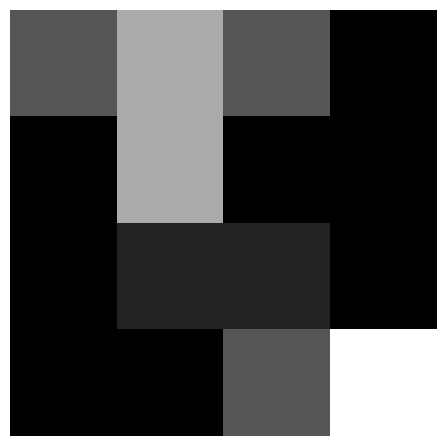

In [449]:
"""
Visualization of matrix block structure
(eg, pairwise similarity or co-occurrence)
Requires scaledimage.py for intensity plots
David Andrzejewski
"""
import numpy as NP
import matplotlib.pyplot as P
import matplotlib.lines as L
import sklearn.cluster as SKLC

# from scaledimage import scaledimage

def blockviz(affinity, nclust, ax=None):
    """ 
    Visualize block-structure of affinity matrix 
    affinity = NxN non-negative affinity matrix
    nclust = number of clusters to use
    ax = matplotlib Axes to draw on 
    Rely on caller to .show()
    """
    # Activate the appropriate Axes in pyplot
    if(ax == None):
        ax = P.figure().gca()
    # Do spectral clustering
    ndata = affinity.shape[0]
    c = SKLC.SpectralClustering(n_clusters=nclust, affinity='linear', random_state=1445)
    c.fit(affinity)
    # Extract cluster labels and sort indices to align with clusters
    sortidx = []
    for ki in range(nclust):
        sortidx += getlabeled(c.labels_, ki)
    sorted_affinity = affinity.copy()
    sorted_affinity = sorted_affinity[sortidx,:]
    sorted_affinity = sorted_affinity[:,sortidx]
    # Intensity plot of affinity
    width = 20
    scaledimage(sorted_affinity,
                pixwidth=width, grayscale=True, ax=ax)
    # Draw recovered cluster boundaries
    kstart = 0
    for ki in range(nclust):    
        clustki = getlabeled(c.labels_, ki)
        drawClust(ax, 
                  kstart,
                  kstart + len(clustki),
                  ndata,
                  scale=width)
        kstart += len(clustki)
    return c.labels_

def logistic(val):
    """ Logistic function """
    return float(1) / (1 + NP.exp(-1 * val))

def getlabeled(labels, ki):
    """ Get indices where labels==ki """
    return [idx for (idx, val) in 
            enumerate(labels) if val == ki]

def drawH(ax, y, xstart, xend):
    """ Draw horiztonal line """
    ax.add_line(L.Line2D([xstart, xend], 
                  [y, y],
                  color='r'))

def drawV(ax, x, ystart, yend):
    """ Draw vertical line """
    ax.add_line(L.Line2D([x, x],
                         [ystart, yend], 
                         color='r'))

def drawClust(ax, kstart, kend, kmax, scale=1):
    """ Draw bounding box for cluster """
    skstart = scale * kstart
    skend = scale * kend
    skmax = scale * kmax
    if(skstart == 0):
        # Upper-left cluster: only draw bottom-right borders
        drawH(ax, skmax-skend, skstart, skend)
        drawV(ax, skend, skmax-skstart, skmax-skend)
    elif(skend == skmax):
        # Lower-right cluster: only draw top-left borders
        drawH(ax, skmax-skstart, skstart, skend)
        drawV(ax, skstart, skmax-skstart, skmax-skend)
    else:
        # Otherwise, draw all 4 borders
        drawH(ax, skmax-skend, skstart, skend)
        drawV(ax, skend, skmax-skstart, skmax-skend)
        drawH(ax, skmax-skstart, skstart, skend)
        drawV(ax, skstart, skmax-skstart, skmax-skend)
        
import numpy as NP
import matplotlib.pyplot as P
import matplotlib.ticker as MT
import matplotlib.cm as CM
 
def scaledimage(W, pixwidth=10, ax=None, grayscale=True):
    """
    Do intensity plot, similar to MATLAB imagesc()
 
    W = intensity matrix to visualize
    pixwidth = size of each W element
    ax = matplotlib Axes to draw on 
    grayscale = use grayscale color map
 
    Rely on caller to .show()
    """
    # N = rows, M = column
    (N, M) = W.shape 
    # Need to create a new Axes?
    if(ax == None):
        ax = P.figure().gca()
    # extents = Left Right Bottom Top
    exts = (0, pixwidth * M, 0, pixwidth * N)
    if(grayscale):
        ax.imshow(W,
                  interpolation='nearest',
                  cmap=CM.gray,
                  extent=exts)
    else:
        ax.imshow(W,
                  interpolation='nearest',
                  extent=exts)
 
    ax.xaxis.set_major_locator(MT.NullLocator())
    ax.yaxis.set_major_locator(MT.NullLocator())
    return ax
 
if __name__ == '__main__':
    # Define a synthetic test dataset
    testweights = NP.array([[0.25, 0.50, 0.25, 0.00],
                            [0.00, 0.50, 0.00, 0.00],
                            [0.00, 0.10, 0.10, 0.00],
                            [0.00, 0.00, 0.25, 0.75]])
    # Display it
    ax = scaledimage(testweights)
    P.show()


In [371]:
import matplotlib.pyplot as plt
%matplotlib inline

array([ 5,  6,  2, 12,  2,  2,  4,  5,  8,  5,  3,  5,  1,  6,  5,  5, 10,
        8, 15,  6,  8,  5,  6, 17,  1,  8,  5, 18, 15,  8,  8,  5,  5,  3,
        0,  1,  6,  5,  5,  5,  1,  5,  5,  8, 14,  8, 15, 10, 19,  4,  3,
        3,  1,  5,  1, 19, 15,  8,  8,  8, 14, 12,  8,  8,  1,  7, 10,  1,
        8,  6,  7,  5,  8, 12,  8, 10,  5,  1,  8,  1,  8, 10,  1, 15,  5,
        1, 12, 12, 10, 15,  1,  8,  8,  2,  8,  8,  8, 15,  8, 18,  9, 12,
        2,  3,  8,  7,  7,  2, 14,  7, 12, 12, 12, 12, 12,  1, 18, 19, 19,
       17,  8,  8,  8,  8,  8, 13,  5,  5,  9,  8,  8, 17, 15, 15, 15,  6,
       15,  6,  6, 15, 12, 15, 15,  6,  4,  8,  8,  2, 15,  8, 12,  8,  1,
        1, 19, 10,  2,  2,  7,  7,  1,  8,  8, 14, 12, 19,  5,  2, 18, 18,
        3, 12,  4,  2,  8,  2,  2, 14, 19,  2,  3, 12,  7, 14,  2,  3,  2,
        8, 12, 15,  8, 17,  8,  1,  1,  8,  1,  5,  5,  1,  1,  1,  3,  5,
        8,  8,  8,  7, 17, 17,  0,  7, 12, 18, 15,  4,  8, 15, 15, 13, 13,
        9, 15,  2, 11, 11

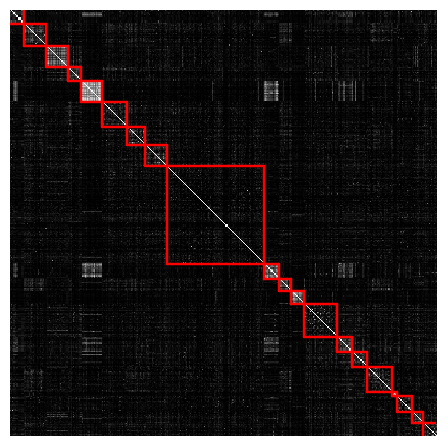

In [455]:
blockviz(np.matrix(af_mat), 20)

#### cosine^

array([ 5,  6,  2, 12,  2,  2,  4,  5,  8,  5,  3,  5,  1,  6,  5,  5, 10,
        8, 15,  6,  8,  5,  6, 17,  1,  8,  5, 18, 15,  8,  8,  5,  5,  3,
        0,  1,  6,  5,  5,  5,  1,  5,  5,  8, 14,  8, 15, 10, 19,  4,  3,
        3,  1,  5,  1, 19, 15,  8,  8,  8, 14, 12,  8,  8,  1,  7, 10,  1,
        8,  6,  7,  5,  8, 12,  8, 10,  5,  1,  8,  1,  8, 10,  1, 15,  5,
        1, 12, 12, 10, 15,  1,  8,  8,  2,  8,  8,  8, 15,  8, 18,  9, 12,
        2,  3,  8,  7,  7,  2, 14,  7, 12, 12, 12, 12, 12,  1, 18, 19, 19,
       17,  8,  8,  8,  8,  8, 13,  5,  5,  9,  8,  8, 17, 15, 15, 15,  6,
       15,  6,  6, 15, 12, 15, 15,  6,  4,  8,  8,  2, 15,  8, 12,  8,  1,
        1, 19, 10,  2,  2,  7,  7,  1,  8,  8, 14, 12, 19,  5,  2, 18, 18,
        3, 12,  4,  2,  8,  2,  2, 14, 19,  2,  3, 12,  7, 14,  2,  3,  2,
        8, 12, 15,  8, 17,  8,  1,  1,  8,  1,  5,  5,  1,  1,  1,  3,  5,
        8,  8,  8,  7, 17, 17,  0,  7, 12, 18, 15,  4,  8, 15, 15, 13, 13,
        9, 15,  2, 11, 11

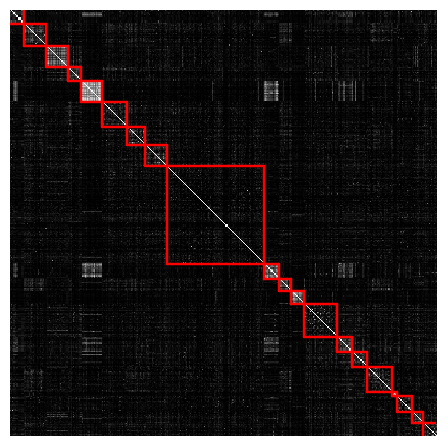

In [500]:
blockviz(np.matrix(af_mat), 20)

#### cosine 50 ^

array([ 2, 14,  8,  2,  8,  8,  3, 18,  7, 18,  7,  7,  0,  7,  2,  7,  7,
        7, 14,  2,  7,  7,  7,  2,  0,  7, 18,  9, 14,  7,  7,  7,  7, 18,
        2,  0, 14,  7,  7,  7,  0,  7,  7,  7, 16,  7, 14,  5,  0,  3, 18,
       18,  0,  7,  0,  7, 14,  7,  2,  2,  7,  2,  7,  7,  7, 12,  5,  0,
        7,  7, 12,  7,  7, 17,  7,  5, 18,  0,  7,  0,  7,  5,  0,  2, 18,
        0,  2,  2,  5, 14,  7,  2,  2,  8,  7,  7,  7,  0,  7, 17,  1,  2,
        8,  7,  7,  7, 12,  8,  7, 12, 17,  2,  2, 17,  2,  7,  7,  0,  0,
        2, 14,  7,  2,  7,  7,  2,  7,  7,  1,  7,  7,  2, 14, 14, 14, 14,
       14, 14, 14, 14,  2, 14, 14, 14,  3,  2,  7,  8,  2,  7,  7,  7,  0,
        0,  2,  5,  7,  8, 12, 12,  7,  7,  7,  2, 17,  2,  7,  8,  9,  9,
       18, 17,  3,  8,  7,  8,  8, 17,  2,  7, 18,  2, 12,  2,  8, 17, 17,
        2,  2, 14,  2,  2,  7,  0,  0,  2,  0,  7,  7,  0,  0,  0, 18,  7,
        2,  7,  7,  7,  2,  2, 12,  7, 17,  9, 14,  3,  2, 14,  7,  2,  2,
        1, 14,  8,  6,  6

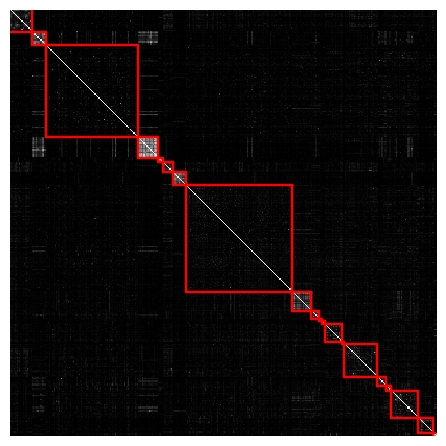

In [464]:
blockviz(np.matrix(af_mat), 20)

#### polynomial

array([ 2, 14,  8,  2,  8,  8,  3, 18,  7, 18,  7,  7,  0,  7,  2,  7,  7,
        7, 14,  2,  7,  7,  7,  2,  0,  7, 18,  9, 14,  7,  7,  7,  7, 18,
        2,  0, 14,  7,  7,  7,  0,  7,  7,  7, 16,  7, 14,  5,  0,  3, 18,
       18,  0,  7,  0,  7, 14,  7,  2,  2,  7,  2,  7,  7,  7, 12,  5,  0,
        7,  7, 12,  7,  7, 17,  7,  5, 18,  0,  7,  0,  7,  5,  0,  2, 18,
        0,  2,  2,  5, 14,  7,  2,  2,  8,  7,  7,  7,  0,  7, 17,  1,  2,
        8,  7,  7,  7, 12,  8,  7, 12, 17,  2,  2, 17,  2,  7,  7,  0,  0,
        2, 14,  7,  2,  7,  7,  2,  7,  7,  1,  7,  7,  2, 14, 14, 14, 14,
       14, 14, 14, 14,  2, 14, 14, 14,  3,  2,  7,  8,  2,  7,  7,  7,  0,
        0,  2,  5,  7,  8, 12, 12,  7,  7,  7,  2, 17,  2,  7,  8,  9,  9,
       18, 17,  3,  8,  7,  8,  8, 17,  2,  7, 18,  2, 12,  2,  8, 17, 17,
        2,  2, 14,  2,  2,  7,  0,  0,  2,  0,  7,  7,  0,  0,  0, 18,  7,
        2,  7,  7,  7,  2,  2, 12,  7, 17,  9, 14,  3,  2, 14,  7,  2,  2,
        1, 14,  8,  6,  6

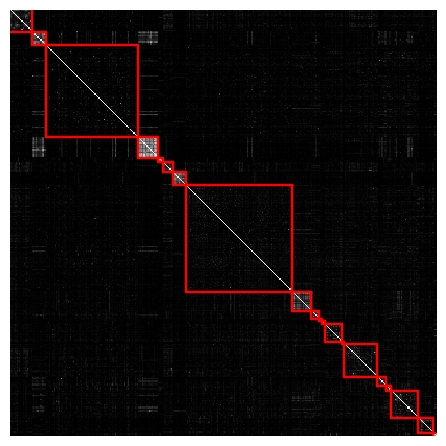

In [495]:
blockviz(np.matrix(af_mat), 20)

#### poly 50 ^

array([ 2, 14,  8,  2,  8,  8,  3, 18,  7, 18,  7,  7,  0,  7,  2,  7,  7,
        7, 14,  2,  7,  7,  7,  2,  0,  7, 18,  9, 14,  7,  7,  7,  7, 18,
        2,  0, 14,  7,  7,  7,  0,  7,  7,  7, 16,  7, 14,  5,  0,  3, 18,
       18,  0,  7,  0,  7, 14,  7,  2,  2,  7,  2,  7,  7,  7, 12,  5,  0,
        7,  7, 12,  7,  7, 17,  7,  5, 18,  0,  7,  0,  7,  5,  0,  2, 18,
        0,  2,  2,  5, 14,  7,  2,  2,  8,  7,  7,  7,  0,  7, 17,  1,  2,
        8,  7,  7,  7, 12,  8,  7, 12, 17,  2,  2, 17,  2,  7,  7,  0,  0,
        2, 14,  7,  2,  7,  7,  2,  7,  7,  1,  7,  7,  2, 14, 14, 14, 14,
       14, 14, 14, 14,  2, 14, 14, 14,  3,  2,  7,  8,  2,  7,  7,  7,  0,
        0,  2,  5,  7,  8, 12, 12,  7,  7,  7,  2, 17,  2,  7,  8,  9,  9,
       18, 17,  3,  8,  7,  8,  8, 17,  2,  7, 18,  2, 12,  2,  8, 17, 17,
        2,  2, 14,  2,  2,  7,  0,  0,  2,  0,  7,  7,  0,  0,  0, 18,  7,
        2,  7,  7,  7,  2,  2, 12,  7, 17,  9, 14,  3,  2, 14,  7,  2,  2,
        1, 14,  8,  6,  6

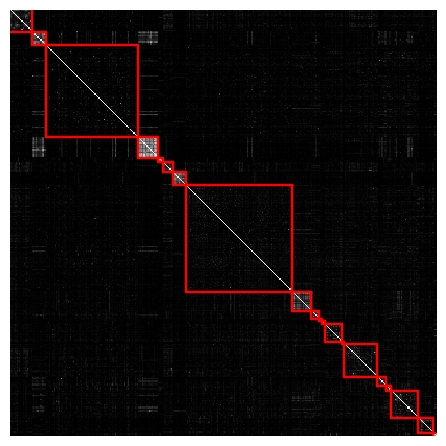

In [494]:
blockviz(np.matrix(af_mat), 20)

#### poly 30

array([ 2, 14,  8,  2,  8,  8,  3, 18,  7, 18,  7,  7,  0,  7,  2,  7,  7,
        7, 14,  2,  7,  7,  7,  2,  0,  7, 18,  9, 14,  7,  7,  7,  7, 18,
        2,  0, 14,  7,  7,  7,  0,  7,  7,  7, 16,  7, 14,  5,  0,  3, 18,
       18,  0,  7,  0,  7, 14,  7,  2,  2,  7,  2,  7,  7,  7, 12,  5,  0,
        7,  7, 12,  7,  7, 17,  7,  5, 18,  0,  7,  0,  7,  5,  0,  2, 18,
        0,  2,  2,  5, 14,  7,  2,  2,  8,  7,  7,  7,  0,  7, 17,  1,  2,
        8,  7,  7,  7, 12,  8,  7, 12, 17,  2,  2, 17,  2,  7,  7,  0,  0,
        2, 14,  7,  2,  7,  7,  2,  7,  7,  1,  7,  7,  2, 14, 14, 14, 14,
       14, 14, 14, 14,  2, 14, 14, 14,  3,  2,  7,  8,  2,  7,  7,  7,  0,
        0,  2,  5,  7,  8, 12, 12,  7,  7,  7,  2, 17,  2,  7,  8,  9,  9,
       18, 17,  3,  8,  7,  8,  8, 17,  2,  7, 18,  2, 12,  2,  8, 17, 17,
        2,  2, 14,  2,  2,  7,  0,  0,  2,  0,  7,  7,  0,  0,  0, 18,  7,
        2,  7,  7,  7,  2,  2, 12,  7, 17,  9, 14,  3,  2, 14,  7,  2,  2,
        1, 14,  8,  6,  6

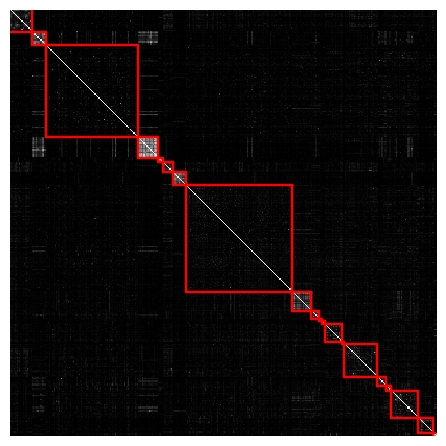

In [485]:
blockviz(np.matrix(af_mat), 20)

#### Poly 20

In [384]:
import seaborn as sns

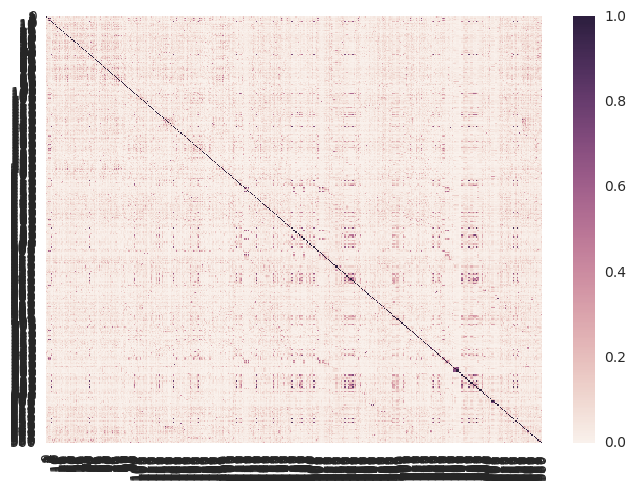